# **Serialisation et Module FASTAPI **

In [97]:
!pip install FastAPI  uvicorn nest-asyncio pyngrok -q

In [98]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/HomeCredit

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/HomeCredit


In [101]:
"""
KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's 
categorical features. Other tables are using one-hot encode with mean, 
sum and a few different functions to aggregate. The main idea was to add 
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def main(debug= False):
    global df
    num_rows = 100 if debug else None
    with timer("application_train and application_test"):
        df = get_train_test(DATA_DIRECTORY, num_rows= num_rows)
        print("Application dataframe shape: ", df.shape)
    with timer("Bureau and bureau_balance data"):
        bureau_df = get_bureau(DATA_DIRECTORY, num_rows= num_rows)
        df = pd.merge(df, bureau_df, on='SK_ID_CURR', how='left')
        print("Bureau dataframe shape: ", bureau_df.shape)
        del bureau_df; gc.collect()
    with timer("previous_application"):
        prev_df = get_previous_applications(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
        print("Previous dataframe shape: ", prev_df.shape)
        del prev_df; gc.collect()
    with timer("previous applications balances"):
        pos = get_pos_cash(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
        print("Pos-cash dataframe shape: ", pos.shape)
        del pos; gc.collect()
    ''' ins = get_installment_payments(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
        print("Installments dataframe shape: ", ins.shape)
        del ins; gc.collect()
    '''
    cc = get_credit_card(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
    print("Credit card dataframe shape: ", cc.shape)
    del cc; gc.collect()
    # Add ratios and groupby between different tables
    df = add_ratios_features(df)
    df = reduce_memory(df)
    lgbm_categorical_feat = [
        'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
        'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']
    return df

def add_ratios_features(df):
    # CREDIT TO INCOME RATIO
    df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
    df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
    # PREVIOUS TO CURRENT CREDIT RATIO
    df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
       
    return df


# ------------------------- LIGHTGBM MODEL deleted -------------------------


# ------------------------- APPLICATION PIPELINE -------------------------

def get_train_test(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    num_rows = 2000
    train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)
    df = train.append(test)
    del train, test; gc.collect()
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)


    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
        df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    # Time ratios
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')

    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    df = drop_application_columns(df)
    return df


def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df


def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0


# ------------------------- BUREAU PIPELINE -------------------------

def get_bureau(path, num_rows= None):
    """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
    bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

    # One-hot encoder
    bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
    # Join bureau balance features
    bureau = bureau.merge(get_bureau_balance(path, num_rows), how='left', on='SK_ID_BUREAU')
    # Flag months with late payments (days past due)
    bureau['STATUS_12345'] = 0
    for i in range(1,6):
        bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

    # Aggregate by number of months in balance and merge with bureau (loan length agg)
    features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
        'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
    agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
    agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
    bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
    del agg_length; gc.collect()

    # General loans aggregations
    agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
    del active, closed; gc.collect()
    # Aggregations for the main loan types
    for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
        type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
        prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
        agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
        del type_df; gc.collect()
    # Time based aggregations: last x months
    for time_frame in [6, 12]:
        prefix = "BUREAU_LAST{}M_".format(time_frame)
        time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
        agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
        del time_frame_df; gc.collect()

    # Last loan max overdue
    sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
    gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
    gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
    agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
    # Ratios: total debt/total credit and active loans debt/ active loans credit
    agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
    agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']
    return agg_bureau


def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    # Calculate rate for each category with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

# ------------------------- PREVIOUS PIPELINE -------------------------

def get_previous_applications(path, num_rows= None):
    """ Process previous_application.csv and return a pandas dataframe. """
    prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

    # One-hot encode most important categorical features
    ohe_columns = [
        'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
        'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
    prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    # Active loans - approved and not complete yet (last_due 365243)
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
    # Find how much was already payed in active loans (using installments csv)
    active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
    active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
    active_pay_agg.reset_index(inplace= True)
    # Active loans: difference of what was payed and installments
    active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
    # Merge with active_df
    active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
    active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
    active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
    # Perform aggregations for active applications
    active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
    active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                             active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
    del active_pay, active_pay_agg, active_df; gc.collect()

    # Change 365.243 values to nan (missing)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

    # Categorical features
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    # Perform general aggregations
    agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
    # Merge active loans dataframe on agg_prev
    agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
    del active_agg_df; gc.collect()
    # Aggregations for approved and refused loans
    agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
    del approved, refused; gc.collect()
    # Aggregations for Consumer loans and Cash loans
    for loan_type in ['Consumer loans', 'Cash loans']:
        type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
        prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
        agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
        del type_df; gc.collect()

    # Get the SK_ID_PREV for loans with late payments (days past due)
    pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
    dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
    # Aggregations for loans with late payments
    agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                    'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
    del agg_dpd, dpd_id; gc.collect()
    # Aggregations for loans in the last x months
    for time_frame in [12, 24]:
        time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
        prefix = 'PREV_LAST{}M_'.format(time_frame)
        agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
        del time_frame_df; gc.collect()
    del prev; gc.collect()
    return agg_prev

# ------------------------- POS-CASH PIPELINE -------------------------

def get_pos_cash(path, num_rows= None):
    """ Process POS_CASH_balance.csv and return a pandas dataframe. """
    pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
    pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
    # Flag months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # Aggregate by SK_ID_CURR
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
    # Sort and group by SK_ID_PREV
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')
    df = pd.DataFrame()
    df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()
    # Percentage of previous loans completed and completed before initial term
    df['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df['POS_COMPLETED_BEFORE_MEAN'] = df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    # Number of remaining installments (future installments) and percentage from total
    df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()
    # Group by SK_ID_CURR and merge
    df_gp = df.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_agg = pd.merge(pos_agg, df_gp, on= 'SK_ID_CURR', how= 'left')
    del df, gp, df_gp, sort_pos; gc.collect()

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')
    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR','LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

    # Drop some useless categorical features
    drop_features = [
        'POS_NAME_CONTRACT_STATUS_Canceled_MEAN', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
        'POS_NAME_CONTRACT_STATUS_XNA_MEAN']
    pos_agg.drop(drop_features, axis=1, inplace=True)
    return pos_agg

# ------------------------- INSTALLMENTS PIPELINE -------------------------

def get_installment_payments(path, num_rows= None):
    """ Process installments_payments.csv and return a pandas dataframe. """
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
    # Group payments and get Payment difference
    pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
    pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
    pay['PAYMENT_RATIO'] = pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']
    pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
    pay['PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
    # Payment Entry: Days past due and Days before due
    pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['DPD'] = pay['DPD'].apply(lambda x: 0 if x <= 0 else x)
    pay['DBD'] = pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']
    pay['DBD'] = pay['DBD'].apply(lambda x: 0 if x <= 0 else x)
    # Flag late payment
    pay['LATE_PAYMENT'] = pay['DBD'].apply(lambda x: 1 if x > 0 else 0)
    # Percentage of payments that were late
    pay['INSTALMENT_PAYMENT_RATIO'] = pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']
    pay['LATE_PAYMENT_RATIO'] = pay.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)
    # Flag late payments that have a significant amount
    pay['SIGNIFICANT_LATE_PAYMENT'] = pay['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
    # Flag k threshold late payments
    pay['DPD_7'] = pay['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    pay['DPD_15'] = pay['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    # Aggregations by SK_ID_CURR
    pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)

    # Installments in the last x months
    for months in [36, 60]:
        recent_prev_id = pay[pay['DAYS_INSTALMENT'] >= -30*months]['SK_ID_PREV'].unique()
        pay_recent = pay[pay['SK_ID_PREV'].isin(recent_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        pay_agg = group_and_merge(pay_recent, pay_agg, prefix, INSTALLMENTS_TIME_AGG)

    # Last x periods trend features
    group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'LATE_PAYMENT',
                      'PAID_OVER_AMOUNT', 'PAID_OVER', 'DAYS_INSTALMENT']
    gp = pay[group_features].groupby('SK_ID_CURR')
    func = partial(trend_in_last_k_instalment_features, periods= INSTALLMENTS_LAST_K_TREND_PERIODS)
    g = parallel_apply(gp, func, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

    # Last loan features
    g = parallel_apply(gp, installments_last_loan_features, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')
    return pay_agg


def trend_in_last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]
        features = add_trend_feature(features, gr_period, 'DPD',
                                           '{}_TREND_'.format(period))
        features = add_trend_feature(features, gr_period, 'PAID_OVER_AMOUNT',
                                           '{}_TREND_'.format(period))
    return features


def installments_last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features = {}
    features = add_features_in_group(features, gr_, 'DPD',
                                     ['sum', 'mean', 'max', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'LATE_PAYMENT',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER_AMOUNT',
                                     ['sum', 'mean', 'max', 'min', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    return features

# ------------------------- CREDIT CARD PIPELINE -------------------------

def get_credit_card(path, num_rows= None):
    """ Process credit_card_balance.csv and return a pandas dataframe. """
    cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
    cc.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)
    # Amount used from limit
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Current payment / Min payment
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
    # Late payment
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Aggregations by SK_ID_CURR
    cc_agg = cc.groupby('SK_ID_CURR').agg(CREDIT_CARD_AGG)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg.reset_index(inplace= True)

    # Last month balance of each credit card application
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})

    # Aggregations for last x months
    for months in [12, 24, 48]:
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        cc_agg = group_and_merge(cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)
    return cc_agg


# ------------------------- UTILITY FUNCTIONS -------------------------

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))


def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()


def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)


def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    """Create a new column for each categorical value in categorical columns. """
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns


def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns


def add_features(feature_name, aggs, features, feature_names, groupby):
    feature_names.extend(['{}_{}'.format(feature_name, agg) for agg in aggs])

    for agg in aggs:
        if agg == 'kurt':
            agg_func = kurtosis
        elif agg == 'iqr':
            agg_func = iqr
        else:
            agg_func = agg

        g = groupby[feature_name].agg(agg_func).reset_index().rename(index=str,
                                                                     columns={feature_name: '{}_{}'.format(feature_name,agg)})
        features = features.merge(g, on='SK_ID_CURR', how='left')
    return features, feature_names


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features


def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features

#funcction for parrallel threading
def parallel_apply(groups, func, index_name='Index', num_workers=0, chunk_size=100000):
    if num_workers <= 0: num_workers = NUM_THREADS
    #n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
    indeces, features = [], []
    for index_chunk, groups_chunk in chunk_groups(groups, chunk_size):
        with mp.pool.Pool(num_workers) as executor:
            features_chunk = executor.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)

    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features


def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)
        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_


def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

# ------------------------- CONFIGURATIONS -------------------------

# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = ""
SUBMISSION_SUFIX = "_model2_04"

# INSTALLMENTS TREND PERIODS
INSTALLMENTS_LAST_K_TREND_PERIODS =  [12, 24, 60, 120]



# AGGREGATIONS
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    # Categorical
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    # Group by loan duration features (months)
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}

BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}

PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}

PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
}


PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LATE_PAYMENTS_AGG = {
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],
}

PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

POS_CASH_AGG = {
    'SK_ID_PREV': ['nunique'],
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'SK_DPD': ['max', 'mean', 'sum', 'var'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
    'LATE_PAYMENT': ['mean']
}

INSTALLMENTS_AGG = {
    'SK_ID_PREV': ['size', 'nunique'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean', 'sum'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
    'PAID_OVER': ['mean']
}

INSTALLMENTS_TIME_AGG = {
    'SK_ID_PREV': ['size'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
}

CREDIT_CARD_AGG = {
    'MONTHS_BALANCE': ['min'],
    'AMT_BALANCE': ['max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF': ['max', 'sum'],
    'LIMIT_USE': ['max', 'mean'],
    'PAYMENT_DIV_MIN': ['min', 'mean'],
    'LATE_PAYMENT': ['max', 'sum'],
}

CREDIT_CARD_TIME_AGG = {
    'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
    'SK_DPD': ['max', 'sum'],
    'AMT_BALANCE': ['mean', 'max'],
    'LIMIT_USE': ['max', 'mean']
}


if __name__ == "__main__":
    def my_score(y_pred,y_true):
        tp = np.sum(y_pred * y_true, axis=0)
        fp = np.sum(y_pred * (1 - y_true), axis=0)
        fn = np.sum((1 - y_pred) * y_true, axis=0)
        cost = 15*fn + 5*fp #/ (2*tp + fn + fp + 1e-16)
        return cost
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.max_columns', 100)
    with timer("Pipeline total time"):
        main(debug= False)

Application dataframe shape:  (4000, 74)
application_train and application_test - done in 1s
Bureau dataframe shape:  (305811, 156)
Bureau and bureau_balance data - done in 41s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Previous dataframe shape:  (338857, 201)
previous_application - done in 70s
Pos-cash dataframe shape:  (337252, 24)
previous applications balances - done in 174s
Credit card dataframe shape:  (103558, 59)
Initial df memory usage is 15.69 MB for 513 columns
Final memory usage is: 5.88 MB - decreased by 62.5%
Pipeline total time - done in 321s


In [102]:
df1=df

In [103]:
df.dtypes

SK_ID_CURR                                 int32
TARGET                                   float16
NAME_CONTRACT_TYPE                          int8
CODE_GENDER                                 int8
FLAG_OWN_CAR                                int8
                                          ...   
INS_48M_LIMIT_USE_MAX                    float64
INS_48M_LIMIT_USE_MEAN                   float64
BUREAU_INCOME_CREDIT_RATIO               float16
BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO     float16
CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO    float16
Length: 513, dtype: object

In [104]:
df=df1
df =df.astype('float')
test = df[df['TARGET'].isnull()]
df = df[df['TARGET'].notnull()]
df.fillna(df.mean(),inplace=True)
df.replace(np.inf, 1000000, inplace=True) 
df.replace(-np.inf, -1, inplace=True)
df.replace(np.nan, 0, inplace=True)

#df =df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [105]:
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,FLOORSMAX_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,WALLSMATERIAL_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_8,FLAG_DOCUMENT_18,...,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_SK_DPD_MEAN,CC_SK_DPD_MAX,CC_SK_DPD_SUM,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_SUM,CC_LIMIT_USE_MAX,CC_LIMIT_USE_MEAN,CC_PAYMENT_DIV_MIN_MIN,CC_PAYMENT_DIV_MIN_MEAN,CC_LATE_PAYMENT_MAX,CC_LATE_PAYMENT_SUM,CC_LAST_AMT_BALANCE_MEAN,CC_LAST_AMT_BALANCE_MAX,INS_12M_CNT_DRAWINGS_ATM_CURRENT_MEAN,INS_12M_SK_DPD_MAX,INS_12M_SK_DPD_SUM,INS_12M_AMT_BALANCE_MEAN,INS_12M_AMT_BALANCE_MAX,INS_12M_LIMIT_USE_MAX,INS_12M_LIMIT_USE_MEAN,INS_24M_CNT_DRAWINGS_ATM_CURRENT_MEAN,INS_24M_SK_DPD_MAX,INS_24M_SK_DPD_SUM,INS_24M_AMT_BALANCE_MEAN,INS_24M_AMT_BALANCE_MAX,INS_24M_LIMIT_USE_MAX,INS_24M_LIMIT_USE_MEAN,INS_48M_CNT_DRAWINGS_ATM_CURRENT_MEAN,INS_48M_SK_DPD_MAX,INS_48M_SK_DPD_SUM,INS_48M_AMT_BALANCE_MEAN,INS_48M_AMT_BALANCE_MAX,INS_48M_LIMIT_USE_MAX,INS_48M_LIMIT_USE_MEAN,BUREAU_INCOME_CREDIT_RATIO,BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO,CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO
0,100002.0,1.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.0,0.0,0.0,0.0,0.0,0.018799,-9461.0,-637.000000,-3648.0,-2120.0,11.94228,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.083008,0.262939,0.139404,0.024704,0.068970,0.083313,0.018997,0.025208,0.083313,0.024994,0.972168,0.068970,0.083313,0.014900,0.0,2.0,2.0,-1134.0,1.0,0.0,0.0,...,71656.977085,9899.084041,285795.791073,1.410380e+09,138183.251695,70819.77877,3.961735,0.539988,9.785838,5.908463,1.252894,23.846287,1.507566,5.920355,22.046632,473.915371,0.547496,1.397237,1000000.0,1000000.0,1000000.0,1000000.0,0.231434,1.668394,78556.553029,79149.920349,0.539988,22.046632,473.915371,71274.826625,139245.413611,1000000.0,1000000.0,0.539988,22.046632,473.915371,71274.826625,139245.413611,1000000.0,1000000.0,0.539988,22.046632,473.915371,71274.826625,139245.413611,1000000.0,1000000.0,0.534180,2.380859,0.440430
1,100003.0,0.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,1.0,1.0,1.0,1.0,0.0,0.003542,-16765.0,-1188.000000,-1186.0,-291.0,11.94228,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.311279,0.622070,0.513003,0.095886,0.034485,0.291748,0.054901,0.092407,0.291748,0.096802,0.984863,0.034485,0.291748,0.071411,1.0,0.0,0.0,-828.0,1.0,0.0,0.0,...,71656.977085,9899.084041,285795.791073,1.410380e+09,138183.251695,70819.77877,3.961735,0.539988,9.785838,5.908463,1.252894,23.846287,1.507566,5.920355,22.046632,473.915371,0.547496,1.397237,1000000.0,1000000.0,1000000.0,1000000.0,0.231434,1.668394,78556.553029,79149.920349,0.539988,22.046632,473.915371,71274.826625,139245.413611,1000000.0,1000000.0,0.539988,22.046632,473.915371,71274.826625,139245.413611,1000000.0,1000000.0,0.539988,22.046632,473.915371,71274.826625,139245.413611,1000000.0,1000000.0,0.941895,3.000000,0.374268
2,100004.0,0.0,1.0,0.0,1.0,67500.0,135000.0,6750.0,135000.0,0.0,0.0,0.0,0.0,0.0,0.010033,-19046.0,-225.000000,-4260.0,-2531.0,26

In [106]:
print("printing column name where infinity is present")
col_name = df.columns.to_series()[np.isnan(df).any()]
print(col_name)

printing column name where infinity is present
Series([], dtype: object)


In [129]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer


'''test = df[df['TARGET'].isnull()]
df = df[df['TARGET'].notnull()]
df.fillna(df.mean(),inplace=True)
df.replace(np.inf, 1000000, inplace=True) 
df.replace(-np.inf, -1, inplace=True) 
'''



scaler = StandardScaler()

X, y = (df.drop(['SK_ID_CURR', 'TARGET'], axis=1),
                df['TARGET'])
X =X.fillna(X.mean())
X = X.replace([np.inf, -np.inf], 1000) 
print(df.describe())
print(X.describe())

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
#X= scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=314)


#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform (X_test)
'''
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X, y)
print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))

X_train, X_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size=0.20, random_state=314)
'''
import lightgbm as lgb
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'logloss', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 30
from sklearn.metrics import make_scorer

def my_score(y_pred,y_true):
    tp = np.sum(y_pred * y_true, axis=0)
    fp = np.sum(y_pred * (1 - y_true), axis=0)
    fn = np.sum((1 - y_pred) * y_true, axis=0)
    cost = 15*fn + 5*fp #/ (2*tp + fn + fp + 1e-16)
    return cost
my_custom_score = make_scorer(my_score, greater_is_better=False)

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier( random_state=314)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    cv=3,
    scoring=my_custom_score,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(X_train, y_train, **fit_params)
gs.predict(X_test)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))



          SK_ID_CURR       TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  \
count    2000.000000  2000.000000         2000.000000  2000.000000   
mean   101166.644000     0.072500            0.100000     0.646000   
std       679.735946     0.259379            0.300075     0.478329   
min    100002.000000     0.000000            0.000000     0.000000   
25%    100576.750000     0.000000            0.000000     0.000000   
50%    101156.500000     0.000000            0.000000     1.000000   
75%    101763.500000     0.000000            0.000000     1.000000   
max    102343.000000     1.000000            1.000000     1.000000   

       FLAG_OWN_CAR  AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  \
count   2000.000000      2.000000e+03  2.000000e+03    2000.000000   
mean       0.346500      1.701188e+05  5.961248e+05   27126.171000   
std        0.475974      1.017594e+05  3.923593e+05   14333.551813   
min        0.000000      2.565000e+04  4.797000e+04    2974.500000   
25%        0.000000

In [108]:
'''from lightgbm import LGBMClassifier

opt_parameters={'colsample_bytree': 0.8885216205885169, 'min_child_samples': 157, 'min_child_weight': 0.1, 'num_leaves': 17, 'reg_alpha': 0, 'reg_lambda': 50, 'subsample': 0.3357756717412073} 

clf.set_params(**gs.best_params_)
clf.fit(X_train, y_train)'''

LGBMClassifier(colsample_bytree=0.952164731370897, metric='recall',
               min_child_samples=111, min_child_weight=0.01, n_estimators=500,
               n_jobs=4, num_leaves=38, objective='binary', random_state=314,
               reg_alpha=0, reg_lambda=0.1, subsample=0.3029313662262354)

In [141]:
print(gs.best_estimator_)

LGBMClassifier(colsample_bytree=0.55607546409401, min_child_samples=103,
               min_child_weight=10.0, num_leaves=22, random_state=314,
               reg_alpha=2, reg_lambda=1, subsample=0.8939112927620336)


In [130]:
clf1=gs.best_estimator_
#clf1.fit(X_train, y_train)


In [109]:
clf = gs

In [139]:
from sklearn.utils.validation import check_is_fitted
check_is_fitted(gs)

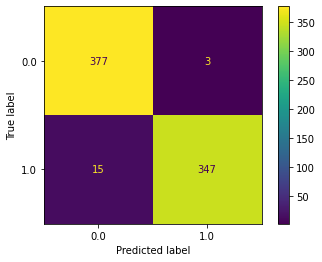

In [124]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gs,X_test,y_test)

In [125]:
import pickle
filename ='model.dat'
with open(filename,'wb') as file :
  pickle.dump(gs, file)

In [144]:
X_train = X_train[['AMT_ANNUITY','EXT_SOURCES_MAX']]
X_test = X_test[['AMT_ANNUITY','EXT_SOURCES_MAX']]

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric= 'logloss', verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.393175	training's binary_logloss: 0.393175	valid_1's binary_logloss: 0.573541	valid_1's binary_logloss: 0.573541


LGBMClassifier(random_state=314)

In [145]:
clf.booster_.save_model('model.txt')


In [114]:
'''from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,X_test,y_test)'''

'from sklearn.metrics import plot_confusion_matrix\nplot_confusion_matrix(clf,X_test,y_test)'

In [115]:
'''fit_params={ 
            "eval_metric" : 'recall', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

clf.fit(X_train,y_train,**fit_params)'''

'fit_params={ \n            "eval_metric" : \'recall\', \n            "eval_set" : [(X_test,y_test)],\n            \'eval_names\': [\'valid\'],\n            #\'callbacks\': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],\n            \'verbose\': 100,\n            \'categorical_feature\': \'auto\'}\n\nclf.fit(X_train,y_train,**fit_params)'

In [116]:
X_test.columns.to_series()[np.isinf(X_test).any()]

Series([], dtype: object)

In [117]:
'''from sklearn.pipeline import Pipeline
import joblib
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


pipeline = make_pipeline(MinMaxScaler(),LGBMClassifier(colsample_bytree=0.9501241488957805, metric='recall',
               min_child_samples=301, min_child_weight=0.1, n_estimators=500,
               n_jobs=4, num_leaves=28, random_state=314, reg_alpha=0,
               reg_lambda=100, subsample=0.9326466073236168))

model = pipeline.fit(X_train, y_train)
joblib.dump(model, 'model.mod') 
joblib.dump(gs.best_estimator_, 'model.pkl') '''

"from sklearn.pipeline import Pipeline\nimport joblib\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.preprocessing import MinMaxScaler\n\n\npipeline = make_pipeline(MinMaxScaler(),LGBMClassifier(colsample_bytree=0.9501241488957805, metric='recall',\n               min_child_samples=301, min_child_weight=0.1, n_estimators=500,\n               n_jobs=4, num_leaves=28, random_state=314, reg_alpha=0,\n               reg_lambda=100, subsample=0.9326466073236168))\n\nmodel = pipeline.fit(X_train, y_train)\njoblib.dump(model, 'model.mod') \njoblib.dump(gs.best_estimator_, 'model.pkl') "

In [148]:
pip freeze > requirements.txt

In [150]:
!python --version

Python 3.7.12
